In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from scipy.ndimage import binary_erosion
import torch
from torchvision.transforms import functional as TF

import pietorch
# Examples to try: image, gif, brain??

# Poisson image editing examples
## Image (2D)

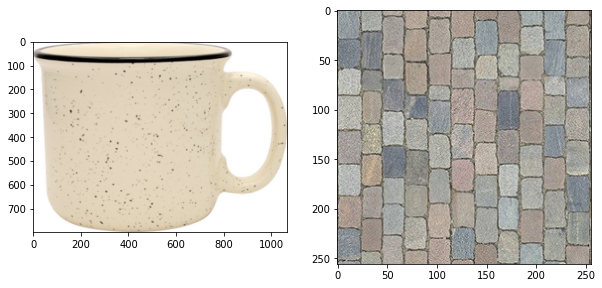

In [2]:
img_1_png = Image.open('example_images/mug.png')
img_1 = Image.new("RGB", img_1_png.size, (255, 255, 255))
img_1.paste(img_1_png, mask=img_1_png.getchannel('A'))

img_2 = Image.open('example_images/brick_texture.jpg')

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(img_1)
ax[1].imshow(img_2)

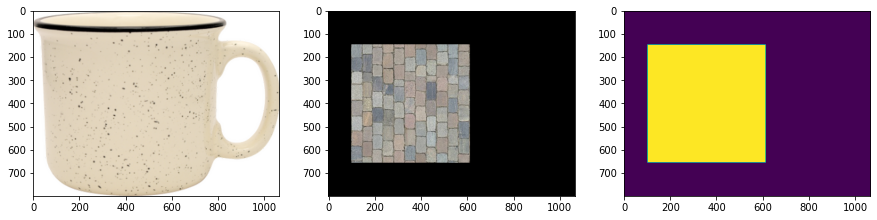

In [3]:
target = TF.to_tensor(img_1)

source = torch.zeros_like(target)
source[:, 144:656, 100:612] = TF.resize(TF.to_tensor(img_2), (512, 512))

mask = torch.zeros(target.shape[1:])
mask[144:656, 100:612] = 1
mask = torch.from_numpy(binary_erosion(mask)).float()

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(torch.movedim(target, 0, -1))
ax[1].imshow(torch.movedim(source, 0, -1))
ax[2].imshow(mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


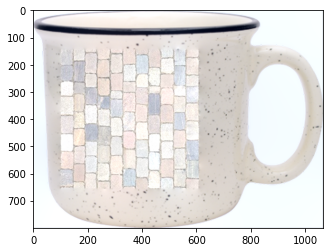

In [4]:
res = pietorch.blend(target, source, mask, False, channels_dim=0)


plt.imshow(torch.movedim(res, 0, -1))

tensor(0.9507)


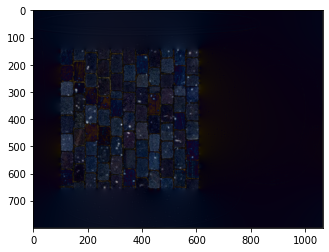

In [5]:
diff = torch.abs(res - target)
print(torch.max(diff))
plt.imshow(torch.movedim(diff, 0, -1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


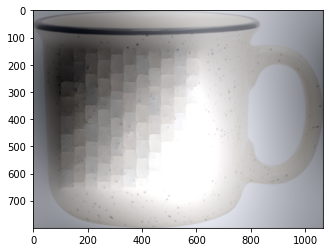

In [14]:
res = pietorch.blend(target, source, mask, True, channels_dim=0)


plt.imshow((torch.movedim(res, 0, -1) - torch.min(res)) / torch.max(res))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(2.0940)


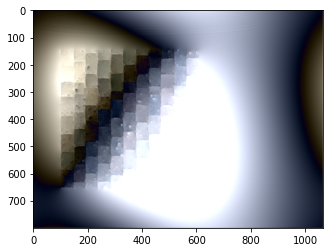

In [7]:
diff = torch.abs(res - target)
print(torch.max(diff))
plt.imshow(torch.movedim(diff, 0, -1))

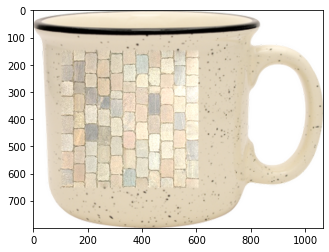

In [8]:
import cv2

cv_img_1 = np.array(img_1)
cv_img_2 = np.array(TF.resize(img_2, (512, 512)))
cv_mask = np.ones(cv_img_2.shape[:2], dtype=np.uint8) * 255

cv_res = cv2.seamlessClone(cv_img_2,
                           cv_img_1,
                           cv_mask,
                           (356, 400),
                           cv2.NORMAL_CLONE)

plt.imshow(cv_res)

212


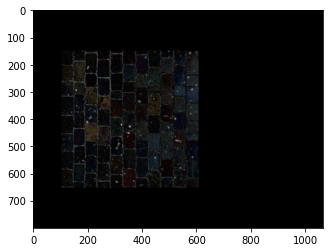

In [9]:
cv_diff = np.abs(cv_img_1.astype(int) - cv_res.astype(int))
print(np.max(cv_diff))

plt.imshow(cv_diff)

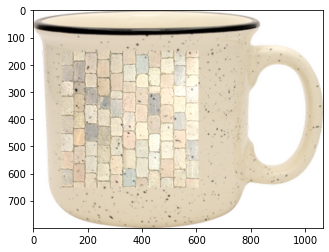

In [10]:
cv_img_1 = np.array(img_1)
cv_img_2 = np.array(TF.resize(img_2, (512, 512)))
cv_mask = np.ones(cv_img_2.shape[:2], dtype=np.uint8) * 255

cv_res = cv2.seamlessClone(cv_img_2,
                           cv_img_1,
                           cv_mask,
                           (356, 400),
                           cv2.MIXED_CLONE)

plt.imshow(cv_res)

111


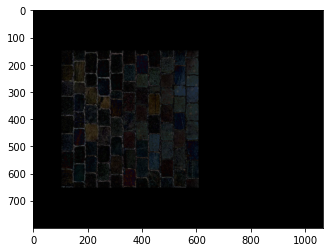

In [11]:
cv_diff = np.abs(cv_img_1.astype(int) - cv_res.astype(int))
print(np.max(cv_diff))

plt.imshow(cv_diff)